# Project Dataset Loading

In [ ]:
import zipfile
import os
import numpy as np
import xml.etree.ElementTree as ET
import glob
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Clone the dataset repository from github
!git clone https://github.com/CodyRichter/Automatic-Short-Answer-Grading

Cloning into 'Automatic-Short-Answer-Grading'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 26 (delta 6), reused 15 (delta 2), pack-reused 0
Unpacking objects: 100% (26/26), done.


In [ ]:
import json

with open('/content/Automatic-Short-Answer-Grading/dataset/train.json', 'r') as tf:
  training_data = json.load(tf)

with open('/content/Automatic-Short-Answer-Grading/dataset/test-unseen-answers.json', 'r') as tf:
  test_unseen_answer_data = json.load(tf)

with open('/content/Automatic-Short-Answer-Grading/dataset/test-unseen-questions.json', 'r') as tf:
  test_unseen_question_data = json.load(tf)

with open('/content/Automatic-Short-Answer-Grading/dataset/test-unseen-domains.json', 'r') as tf:
  test_unseen_domain_data = json.load(tf)

print('Number of Training Data Responses', len(training_data))
print('Number of Test Data (New Answer) Responses', len(test_unseen_answer_data))
print('Number of Test Data (New Question) Responses', len(test_unseen_question_data))
print('Number of Test Data (New Domain) Responses', len(test_unseen_domain_data))

Number of Training Data Responses 8901
Number of Test Data (New Answer) Responses 540
Number of Test Data (New Question) Responses 733
Number of Test Data (New Domain) Responses 4562


## Batching and Loading Data to Model

Use this iterator to load in the train and test datasets to the model of choice.

In [ ]:
#Set up training_data & test_data
test_data = test_unseen_question_data
print(training_data[0])
print(len(training_data))
print(len(test_data))

{'question': 'Look at the finger patterns below, then answer the questions. What is the same about the finger patterns?', 'ref': 'Both finger patterns are loops.', 'response': 'One is a loop and the other is an arc.', 'score': 'incorrect', 'aug': True}
8901
733


## Installation
---

In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 3.8 MB/s 
     |████████████████████████████████| 4.0 MB 28.1 MB/s 
     |████████████████████████████████| 1.2 MB 41.0 MB/s 
     |████████████████████████████████| 77 kB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 32.3 MB/s 
     |████████████████████████████████| 880 kB 40.1 MB/s 
     |████████████████████████████████| 596 kB 20.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=27154dc5a05bb99a14dcd042c37163252cd679356850e07e0f055a114c3b4fb5
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=3db04f317417b3edaa6e01608ddc1f1ef3cfba6b2c4e44e5bf3e8fecb61ca65c
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sentence-transformers sa

In [ ]:
from sentence_transformers import SentenceTransformer, util
# model = SentenceTransformer('all-MiniLM-L6-v2')
# Same model as the BERT_baseline approach
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

## Create inputs for similarity check
---

In [ ]:
# Concate the reference answer and student answer to creat new input for both train and test set
train_data_response = []
train_data_ref = []
train_data_score = []
test_data_response = []
test_data_ref = []
test_data_score = []

for training_item in training_data:
  train_data_response.append(training_item["response"])
  train_data_ref.append(training_item["ref"])
  train_data_score.append(training_item["score"])


for test_item in test_data:
  test_data_response.append(test_item["response"])
  test_data_ref.append(test_item["ref"])
  test_data_score.append(test_item["score"])

print("Train")
print(len(train_data_response))
print(len(train_data_ref))
print(len(train_data_score))
print("Test")
print(len(test_data_response))
print(len(test_data_ref))
print(len(test_data_score))



Train
8901
8901
8901
Test
733
733
733


## Sentence similarity calculation

resource: https://www.sbert.net/docs/usage/semantic_textual_similarity.html
---

In [ ]:
#Compute embedding for both lists
embeddings1 = model.encode(train_data_ref, convert_to_tensor=True)
embeddings2 = model.encode(train_data_response, convert_to_tensor=True)

#Compute euclidean distance of the sentence embeddings
euclidean_dist = torch.cdist(embeddings1, embeddings2, p=2)
print(euclidean_dist.size())

torch.Size([8901, 8901])


In [ ]:
# change the variable name match the rest of the code
cosine_scores = euclidean_dist

## Visualize data
---

In [ ]:
# graph the cos score with label
import numpy as np
import matplotlib.pyplot as plt

correct_answer_sim_scores = []
incorrect_answer_sim_scores = []
for i in range(len(train_data_ref)):
  if train_data_score[i] == 'correct':
    correct_answer_sim_scores.append(cosine_scores[i][i].item())
  else:
    incorrect_answer_sim_scores.append(cosine_scores[i][i].item())



3593


(array([  9.,  17., 141., 476., 781., 967., 797., 321.,  82.,   2.]),
 array([ 0.        ,  1.06066809,  2.12133617,  3.18200426,  4.24267235,
         5.30334044,  6.36400852,  7.42467661,  8.4853447 ,  9.54601278,
        10.60668087]),
 <a list of 10 Patch objects>)

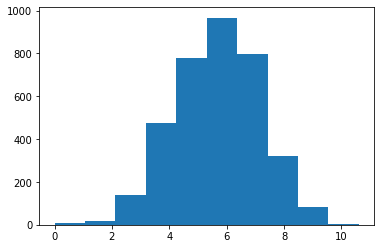

In [ ]:
print(len(correct_answer_sim_scores))
plt.hist(correct_answer_sim_scores)


5308
[6.91552209854126, 8.545393943786621, 10.108011245727539, 5.140951156616211, 8.483799934387207, 7.864750385284424, 8.976951599121094, 9.483083724975586, 6.042665958404541, 8.780439376831055, 7.436689853668213, 7.076913356781006, 9.368383407592773, 6.7188310623168945, 9.36156177520752, 4.97480583190918, 9.063394546508789, 7.990396976470947, 6.644561767578125, 10.440709114074707, 8.854705810546875, 7.033698081970215, 5.9970855712890625, 6.330752849578857, 8.638925552368164, 7.720707416534424, 9.016240119934082, 7.526238918304443, 7.378210544586182, 6.414278507232666, 9.926050186157227, 9.09326171875, 7.71270227432251, 9.86883544921875, 9.114214897155762, 9.875654220581055, 8.517420768737793, 8.211801528930664, 5.938324451446533, 9.692000389099121, 8.359395980834961, 9.259075164794922, 10.175122261047363, 9.369112968444824, 8.74380111694336, 8.75780200958252, 8.299910545349121, 4.927994728088379, 9.83469295501709, 8.022154808044434, 7.110044956207275, 5.196800708770752, 6.81916570663

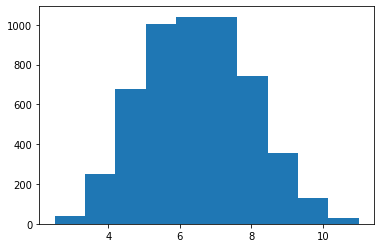

In [ ]:
# Similarity scores 
print(len(incorrect_answer_sim_scores))
plt.hist(incorrect_answer_sim_scores)
print(incorrect_answer_sim_scores)

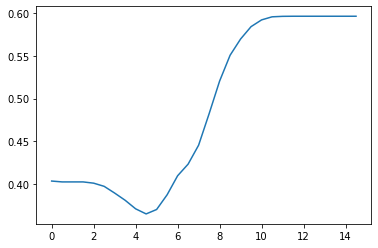

In [ ]:
#Output the pairs with their score
# for i in range(len(test_data_ref)):
#     print("{} \t\t {} \t\t Score: {:.4f}".format(test_data_ref[i], test_data_response[i], cosine_scores[i][i]))
accuracy = []
threshold = []
for i in range(0,150,5):
  threshold_num = i/10;
  result_score = []
  for i in range(len(train_data_ref)):
    if cosine_scores[i][i] >= threshold_num:
      result_score.append("correct")
    else:
      result_score.append("incorrect")

  correct_predict = 0
  for i in range(len(result_score)):
    if result_score[i] == train_data_score[i]:
      correct_predict += 1

  accuracy.append(correct_predict / len(result_score))
  threshold.append(threshold_num)

plt.plot(threshold, accuracy)

In [ ]:
max_accuracy_idx = accuracy.index(max(accuracy))
print("Threshold = " + str(threshold[max_accuracy_idx]))
print("Validation Accuracy = " + str(accuracy[max_accuracy_idx]))
best_threshold = threshold[max_accuracy_idx]

Threshold = 11.5
Validation Accuracy = 0.5963374901696439


## Testing on Testset
----

In [ ]:
#Compute embedding for both lists
embeddings1 = model.encode(test_data_ref, convert_to_tensor=True)
embeddings2 = model.encode(test_data_response, convert_to_tensor=True)

#Compute cosine-similarits
cosine_scores = util.cos_sim(embeddings1, embeddings2)

# Generate prediction & Calculate accuracy
result_score = []
for i in range(len(test_data_ref)):
    if cosine_scores[i][i] >= best_threshold:
      result_score.append("correct")
    else:
      result_score.append("incorrect")

correct_predict = 0
for i in range(len(result_score)):
  if result_score[i] == test_data_score[i]:
    correct_predict += 1

print("Testing accuracy:")
print(correct_predict / len(result_score))

Testing accuracy:
0.5893587994542974


## Conclusion

cos simlarity performs better than using euclidean distance 